In [1]:
%load_ext autoreload
%autoreload 2

from src.config import config
from pathlib import Path
import nibabel as nib
data_dir = Path(config["DATA_DIR"]) / "TotalSeg" 


Loaded configuration for machine: nora


In [1]:
import sys
sys.path.append("/nfs/norasys/notebooks/camaret/repos/Medverse")
from medverse.data.totalseg_dataloader import get_dataloader


In [2]:
stats_dict_path = Path(config["DATA_DIR"]) / "TotalSeg" /"dataset_stats.json"
# open json file
import json
with open(stats_dict_path, 'r') as f:
    stats_dict = json.load(f)

empty_segmentations = stats_dict['empty_segmentations']
print(empty_segmentations)

{'brachiocephalic_vein_right': ['s0000', 's0001', 's0002', 's0003', 's0006', 's0009', 's0010', 's0012', 's0013', 's0014', 's0015', 's0016', 's0022', 's0025', 's0030', 's0031', 's0034', 's0038', 's0039', 's0042', 's0043', 's0045', 's0048', 's0052', 's0053', 's0054', 's0057', 's0058', 's0062', 's0066', 's0068', 's0069', 's0072', 's0073', 's0074', 's0075', 's0077', 's0078', 's0081', 's0082', 's0085', 's0088', 's0089', 's0090', 's0092', 's0096', 's0098', 's0099', 's0100', 's0101', 's0103', 's0104', 's0105', 's0106', 's0107', 's0108', 's0109', 's0117', 's0119', 's0120', 's0122', 's0128', 's0129', 's0131', 's0132', 's0133', 's0135', 's0137', 's0139', 's0140', 's0143', 's0147', 's0150', 's0151', 's0153', 's0156', 's0157', 's0158', 's0159', 's0160', 's0161', 's0165', 's0166', 's0168', 's0174', 's0178', 's0179', 's0182', 's0183', 's0187', 's0188', 's0190', 's0192', 's0193', 's0194', 's0199', 's0201', 's0204', 's0206', 's0208', 's0210', 's0211', 's0212', 's0213', 's0215', 's0216', 's0217', 's021

In [4]:
stats_dict.keys()

dict_keys(['total_cases', 'valid_cases', 'missing_ct', 'missing_seg_folder', 'case_ids', 'empty_segmentations'])

In [9]:
organ_list = [
    "brain",
    "kidney_left",
    "kidney_right",
    "spleen",
    "liver",
]


context_size = 3

val_loader = get_dataloader(
    root_dir=data_dir,
    organ_list=organ_list,
    empty_segmentations=empty_segmentations,
    context_size=context_size,
    batch_size=1,
    image_size=None,  # Dynamically resize to target size
    spacing=(1.5, 1.5, 1.5),
    num_workers=4,
    mode='val',
    shuffle=False,
    random_context=True,        # Use same contexts for reproducibility
)



Found 1228 cases in /nfs/data/nii/data1/Analysis/camaret___in_context_segmentation/ANALYSIS_20251122/data/TotalSeg
Built organ-to-cases mapping for 5 organs
Filtered to 1133 cases with at least one organ from organ_list


/software/anaconda3/envs/incontext/lib/python3.13/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


In [6]:
import torch
from medverse.lightning_model import LightningModel
model_path = "/nfs/norasys/notebooks/camaret/repos/Medverse/Medverse.ckpt"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = LightningModel.load_from_checkpoint(model_path, map_location=device).to(device).eval()



Processing batch 1/1133
GT voxels: 33080.0
Prediction shape: torch.Size([1, 1, 249, 185, 213]), Target shape: torch.Size([1, 1, 249, 185, 213])
  Predicted voxels: 31493.0, Target voxels: 33080.0
  Dice score: 0.9716


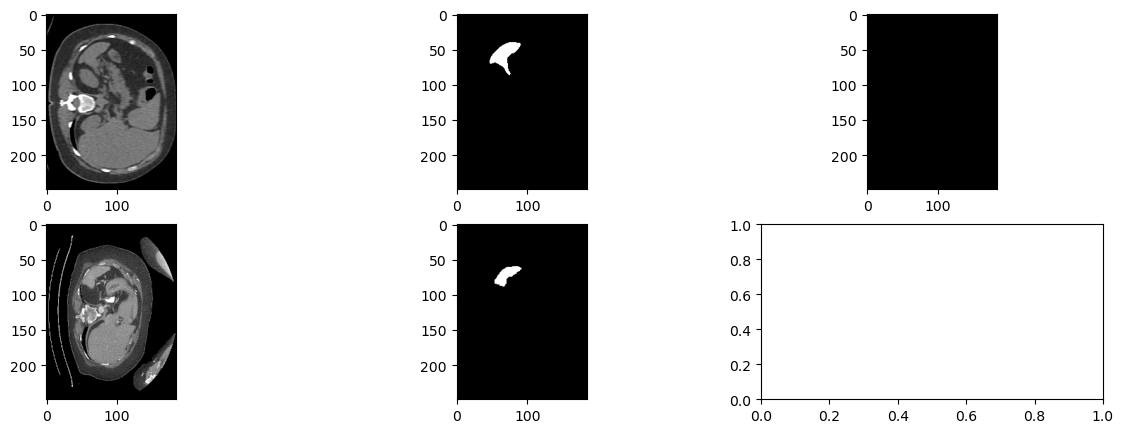

Processing batch 2/1133
GT voxels: 24803.0
Prediction shape: torch.Size([1, 1, 185, 128, 101]), Target shape: torch.Size([1, 1, 185, 128, 101])
  Predicted voxels: 24645.0, Target voxels: 24803.0
  Dice score: 0.8662


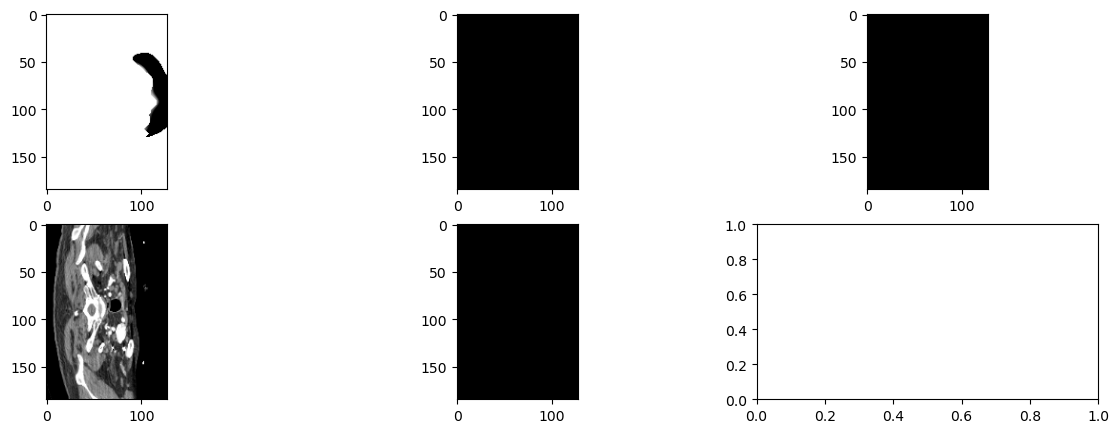

Processing batch 3/1133
GT voxels: 27900.0
Prediction shape: torch.Size([1, 1, 127, 127, 126]), Target shape: torch.Size([1, 1, 127, 127, 126])
  Predicted voxels: 32829.0, Target voxels: 27900.0
  Dice score: 0.7838


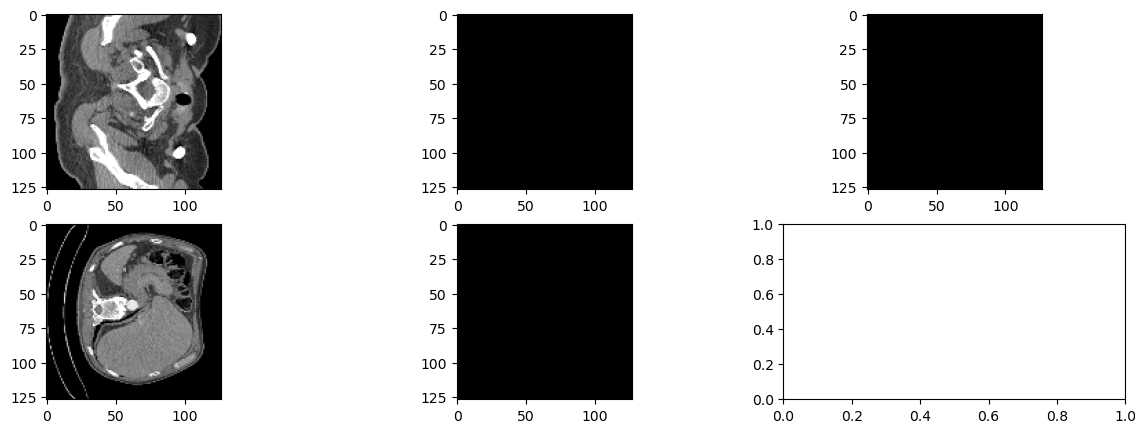

Processing batch 4/1133
GT voxels: 32706.0
Prediction shape: torch.Size([1, 1, 253, 177, 427]), Target shape: torch.Size([1, 1, 253, 177, 427])
  Predicted voxels: 44526.0, Target voxels: 32706.0
  Dice score: 0.7638


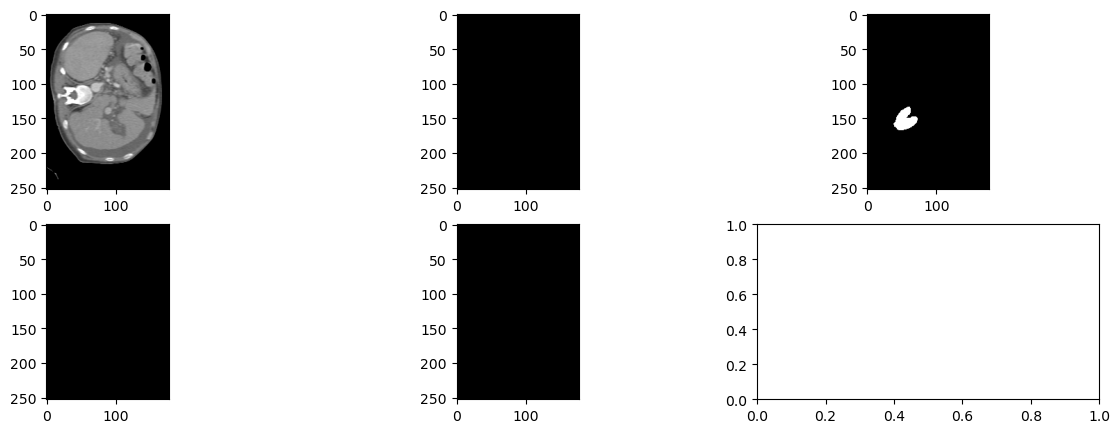

Processing batch 5/1133
GT voxels: 38073.0
Prediction shape: torch.Size([1, 1, 216, 211, 217]), Target shape: torch.Size([1, 1, 216, 211, 217])
  Predicted voxels: 39225.0, Target voxels: 38073.0
  Dice score: 0.9538


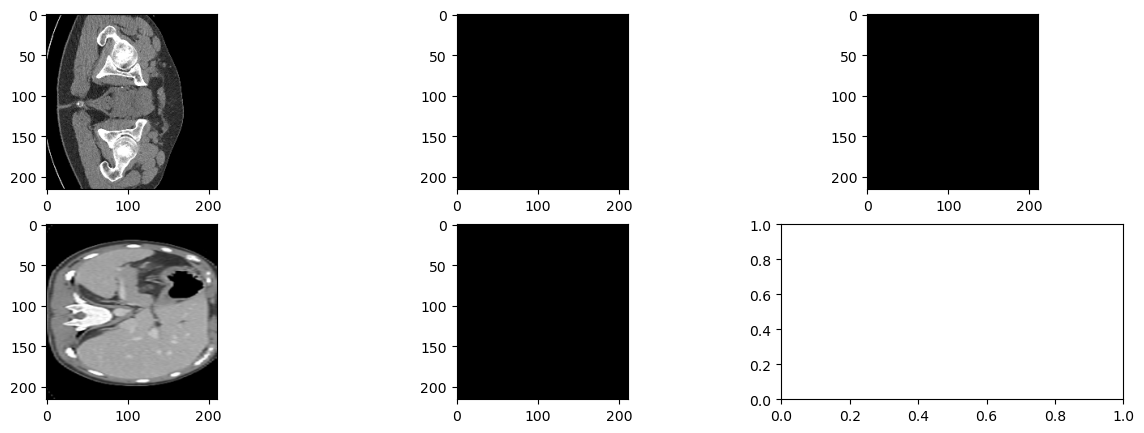

Processing batch 6/1133
GT voxels: 8159.0
Prediction shape: torch.Size([1, 1, 119, 119, 185]), Target shape: torch.Size([1, 1, 119, 119, 185])
  Predicted voxels: 0.0, Target voxels: 8159.0
  Dice score: 0.0000


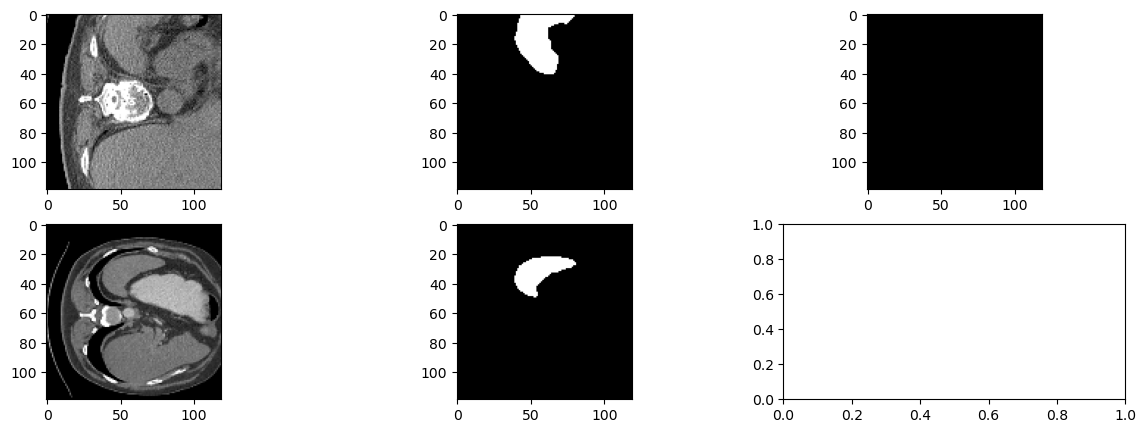

In [10]:
import matplotlib.pyplot as plt

dice_scores = []
for i, batch in enumerate(val_loader):
    print(f"Processing batch {i+1}/{len(val_loader)}")
    # plot target_in, context_in, context_out
    fig, ax = plt.subplots(2, 3, figsize=(15, 5))
    # compute target slice with most foreground voxels
    mri_slice = batch['target_in'][0, 0, :, :, :].sum(dim=(0, 1))
    slice_idx = torch.argmax(mri_slice).item()
    ax[0, 0].imshow(batch['target_in'][0, 0, :, :, slice_idx], cmap='gray')
    ax[0, 1].imshow(batch['target_out'][0, 0, :, :, slice_idx], cmap='gray')

    mri_slice_context = batch['context_in'][0, 0, 0, :, :, :].sum(dim=(0, 1))
    slice_idx_context = torch.argmax(mri_slice_context).item()
    ax[1, 0].imshow(batch['context_in'][0, 0, 0, :, :, slice_idx_context], cmap='gray')
    ax[1, 1].imshow(batch['context_out'][0, 0, 0, :, :, slice_idx_context], cmap='gray')
    
    print("GT voxels:", batch['target_out'].sum().item())

    target_in = batch['target_in'].cuda()
    context_in = batch['context_in'].cuda()
    context_out = batch['context_out'].cuda()

    with torch.no_grad():
        prediction = model.autoregressive_inference(
            target_in=target_in,
            context_in=context_in,
            context_out=context_out,
            level=None,
            forward_l_arg=3,
            sw_roi_size=(128, 128, 128),
            sw_overlap=0.25,
            sw_batch_size_val=1,
        )

    prediction_binary = (prediction > 0.5).float()
    prediction_binary_cpu = prediction_binary.cpu()
    ax[0, 2].imshow(prediction_binary_cpu[0, 0, :, :, prediction_binary_cpu.shape[4] // 2], cmap='gray')
    target_out = batch['target_out'].cuda()
    print(f"Prediction shape: {prediction.shape}, Target shape: {target_out.shape}")
    print(f"  Predicted voxels: {prediction_binary.sum().item()}, Target voxels: {target_out.sum().item()}")
    intersection = (prediction_binary * target_out).sum()
    dice = (2.0 * intersection) / (prediction_binary.sum() + target_out.sum() + 1e-8)
    dice_scores.append(dice.item())
    print(f"  Dice score: {dice.item():.4f}")
    plt.show()

    if i >= 5:  # Limit to first samples for demo
        break

In [32]:
case_list = sorted([p.name for p in data_dir.iterdir() if p.is_dir()])
shapes = []
for case_id in case_list:
    src_img = data_dir / case_id / "ct.nii.gz"
    src_lab = data_dir / case_id / "segmentations" / "aorta.nii.gz"
    print(f"Processing case: {case_id}")
    
    img = nib.load(src_img)
    shapes.append(img.shape)

Processing case: s0000
Processing case: s0001
Processing case: s0002
Processing case: s0003
Processing case: s0004
Processing case: s0006
Processing case: s0009
Processing case: s0010
Processing case: s0011
Processing case: s0012
Processing case: s0013
Processing case: s0014
Processing case: s0015
Processing case: s0016
Processing case: s0019
Processing case: s0021
Processing case: s0022
Processing case: s0024
Processing case: s0025
Processing case: s0028
Processing case: s0029
Processing case: s0030
Processing case: s0031
Processing case: s0032
Processing case: s0034
Processing case: s0035
Processing case: s0036
Processing case: s0037
Processing case: s0038
Processing case: s0039
Processing case: s0040
Processing case: s0042
Processing case: s0043
Processing case: s0044
Processing case: s0045
Processing case: s0046
Processing case: s0048
Processing case: s0049
Processing case: s0050
Processing case: s0052
Processing case: s0053
Processing case: s0054
Processing case: s0056
Processing 

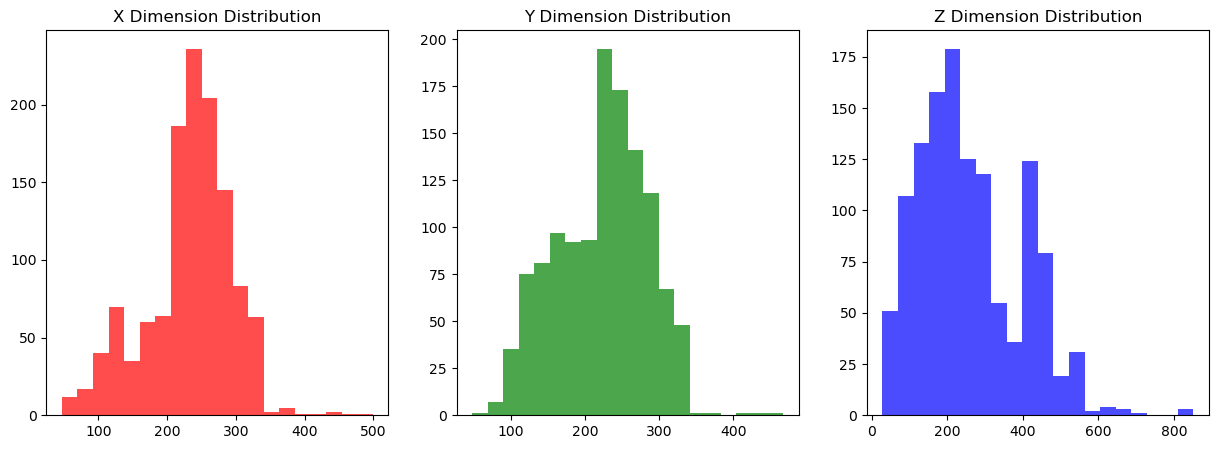

In [33]:
# plot x y z shape distributions
import matplotlib.pyplot as plt
import numpy as np  
shapes = np.array(shapes)
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].hist(shapes[:, 0], bins=20, color='r', alpha=0.7)
ax[0].set_title("X Dimension Distribution")
ax[1].hist(shapes[:, 1], bins=20, color='g', alpha=0.7)
ax[1].set_title("Y Dimension Distribution")
ax[2].hist(shapes[:, 2], bins=20, color='b', alpha=0.7)
ax[2].set_title("Z Dimension Distribution")
plt.show()

In [11]:
case_id = "s0001"

src_img = origin_dir / case_id / "ct.nii.gz"
src_lab = origin_dir / case_id / "segmentations" / "aorta.nii.gz"

img = nib.load(src_img)
lab = nib.load(src_lab)
print(f"Image shape: {img.shape}, Label shape: {lab.shape}")
print(f"Image affine:\n{img.affine}\nLabel affine:\n{lab.affine}")
print(f"Unique labels in segmentation: {set(lab.get_fdata().flatten())}")

Image shape: (249, 188, 213), Label shape: (249, 188, 213)
Image affine:
[[ 1.49672401e+00  3.48045491e-02 -9.28383470e-02 -1.74172134e+02]
 [-3.45467702e-02  1.49959612e+00  2.14285660e-03  2.55811043e+01]
 [ 9.28630605e-02  0.00000000e+00  1.49712265e+00  4.00303900e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Label affine:
[[ 1.49672401e+00  3.48045491e-02 -9.28383470e-02 -1.74172134e+02]
 [-3.45467702e-02  1.49959612e+00  2.14285660e-03  2.55811043e+01]
 [ 9.28630605e-02  0.00000000e+00  1.49712265e+00  4.00303900e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Unique labels in segmentation: {np.float64(0.0), np.float64(1.0)}


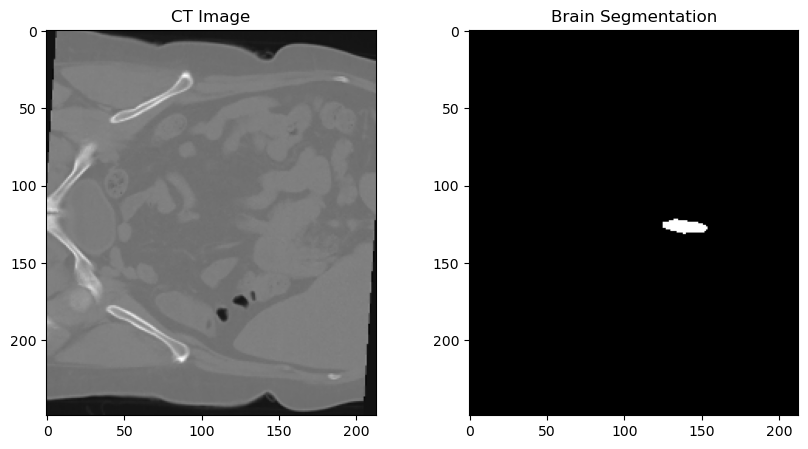

In [12]:
# plot image and label
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img.get_fdata()[:, img.shape[1] // 2, : ], cmap="gray")
ax[0].set_title("CT Image")
ax[1].imshow(lab.get_fdata()[:, lab.shape[1] // 2, :], cmap="gray")
ax[1].set_title("Brain Segmentation")
plt.show()